In [2]:
### each clade -> how many homo/hetero genes linked

import pandas as pd
import numpy as np
from scipy.spatial import distance

threshold = 30000

### extract clade information
NLR_list = pd.read_csv("original_data/tomato_clade_info_myself.csv")
clade_info = NLR_list.loc[:, ["gene_short_na", "NLR clade"]]
clade_info.columns = ["id", "clade"]

### extract gene_distance info
NLR_gene_info = pd.read_csv("original_data/NLR_gene_info.csv", index_col=0)
position_data = NLR_gene_info.iloc[:, [0,3,4,9]]
position_data.columns = ["chr", "start", "end", "id"]

### merge both data
position_data = pd.merge(position_data, clade_info, on='id')
position_data = position_data.sort_values(["clade", "id"])

### calculate distances
def calc_distance(data_from_chr):
    tmp_position_data = data_from_chr.iloc[:, 1]
    tmp_position_data = np.stack([np.array(tmp_position_data), np.zeros(tmp_position_data.shape[0])], 1)

    dist = distance.cdist(tmp_position_data, tmp_position_data, metric='euclidean')
    return dist

dist = pd.DataFrame(calc_distance(position_data))
dist.index = position_data["chr"].values
dist.columns = position_data["chr"].values

position_data['id_clade'] = position_data['id'].str.cat(position_data['clade'], sep='-')

for i in range(dist.shape[0]):
    diff_chr = dist.columns != dist.index[i]
    dist.iloc[i, :].loc[diff_chr] = threshold

dist = np.array(dist)
dist[dist==0] = threshold
dist[dist>threshold] = threshold

distance_data = pd.DataFrame(dist)
distance_data.index = position_data["clade"].values
distance_data.columns = position_data["id"].values

all_results = []
for each_clade in distance_data.index.unique():
    if isinstance(distance_data.loc[each_clade, :], pd.DataFrame):
        less_30000 = distance_data.loc[each_clade, :].sum() < threshold * distance_data.loc[each_clade, :].shape[0]
        homo_genes = less_30000[position_data["clade"].values == each_clade]
        homo_genes = homo_genes.index[homo_genes].values
        hetero_genes = less_30000[position_data["clade"].values != each_clade]
        hetero_genes = hetero_genes.index[hetero_genes].values
        each_data = [each_clade, sum(less_30000), sum(less_30000[position_data["clade"].values == each_clade]), sum(less_30000[position_data["clade"].values != each_clade]), homo_genes, hetero_genes]
        all_results.append(each_data)
    else:
        less_30000 = distance_data.loc[each_clade, :] < threshold
        homo_genes = less_30000[position_data["clade"].values == each_clade]
        homo_genes = homo_genes.index[homo_genes].values
        hetero_genes = less_30000[position_data["clade"].values != each_clade]
        hetero_genes = hetero_genes.index[hetero_genes].values
        each_data = [each_clade, sum(less_30000), sum(less_30000[position_data["clade"].values == each_clade]), sum(less_30000[position_data["clade"].values != each_clade]), homo_genes, hetero_genes]
        all_results.append(each_data)
all_results = pd.DataFrame(all_results)
all_results.columns = ["clade", "all linked gene num", "homo cluster gene num", "hetero cluster gene num", "homo cluster gene", "hetero cluster gene"]
all_results

,clade,all linked gene num,homo cluster gene num,hetero cluster gene num,homo cluster gene,hetero cluster gene
0,CNL-1,9,9,0,"[Solyc05g053990, Solyc05g054010, Solyc05g05402...",[]
1,CNL-10,8,8,0,"[Solyc05g009740, Solyc05g009750, Solyc05g00976...",[]
2,CNL-11,5,5,0,"[Solyc05g007610, Solyc05g007630, Solyc05g00764...",[]
3,CNL-13,4,4,0,"[Solyc04g011960, Solyc04g011980, Solyc04g01199...",[]
4,CNL-15,0,0,0,[],[]
5,CNL-16,0,0,0,[],[]
6,CNL-2,4,2,2,"[Solyc12g009450, Solyc12g009460]","[Solyc04g015210, Solyc08g005510]"
7,CNL-3,4,4,0,"[Solyc11g006520, Solyc11g006530, Solyc11g00663...",[]
8,CNL-4,4,4,0,"[Solyc09g092280, Solyc09g092290, Solyc09g09230...",[]
9,CNL-5,9,9,0,"[Solyc04g009110, Solyc04g009120, Solyc04g00913...",[]


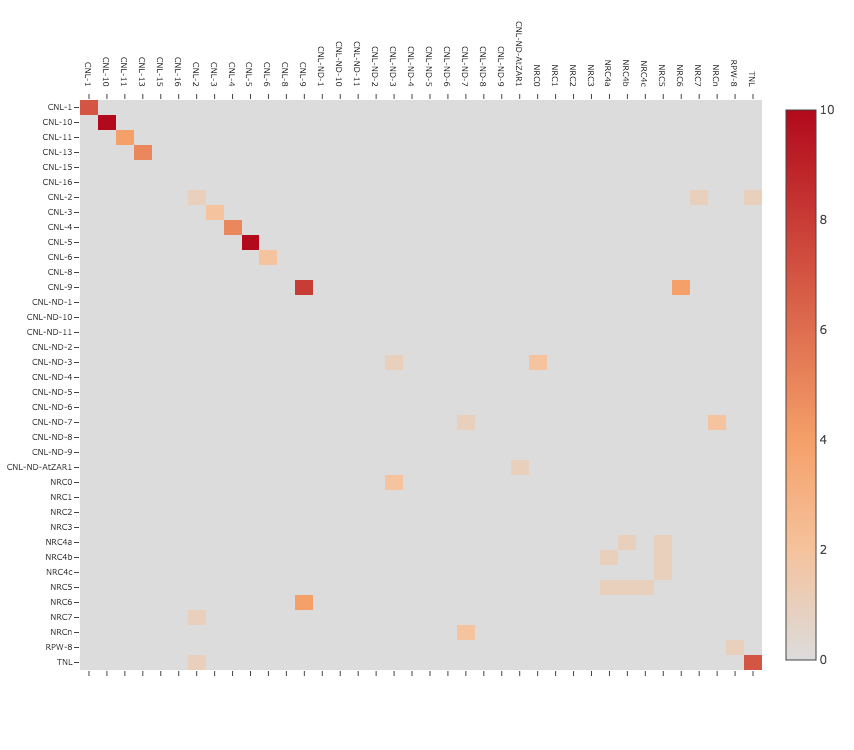

In [4]:
### clade vs clade

import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

threshold = 30000

### extract clade information
NLR_list = pd.read_csv("original_data/tomato_clade_info_myself.csv")
clade_info = NLR_list.loc[:, ["gene_short_na", "NLR clade"]]
clade_info.columns = ["id", "clade"]

### extract gene_distance info
NLR_gene_info = pd.read_csv("original_data/NLR_gene_info.csv", index_col=0)
position_data = NLR_gene_info.iloc[:, [0,3,4,9]]
position_data.columns = ["chr", "start", "end", "id"]

### merge both data
position_data = pd.merge(position_data, clade_info, on='id')
position_data = position_data.sort_values(["clade", "id"])

### calculate distances
def calc_distance(data_from_chr):
    tmp_position_data = data_from_chr.iloc[:, 1]
    tmp_position_data = np.stack([np.array(tmp_position_data), np.zeros(tmp_position_data.shape[0])], 1)

    dist = distance.cdist(tmp_position_data, tmp_position_data, metric='euclidean')
    return dist

dist = pd.DataFrame(calc_distance(position_data))
dist.index = position_data["chr"].values
dist.columns = position_data["chr"].values

position_data['id_clade'] = position_data['id'].str.cat(position_data['clade'], sep='-')

for i in range(dist.shape[0]):
    diff_chr = dist.columns != dist.index[i]
    dist.iloc[i, :].loc[diff_chr] = threshold

dist = np.array(dist)
dist[dist==0] = threshold
dist[dist>threshold] = threshold

distance_data = pd.DataFrame(dist)
distance_data.index = position_data["clade"].values
distance_data.columns = position_data["clade"].values

all_results = []
for clade_1 in distance_data.index.unique():
    each_line = []
    for clade_2 in distance_data.index.unique():
        each_block = distance_data.loc[clade_1, clade_2] < threshold
        if isinstance(distance_data.loc[clade_1, clade_2], pd.DataFrame):
            number_of_genes = sum(sum(each_block.values))
        elif isinstance(distance_data.loc[clade_1, clade_2], pd.Series):
            number_of_genes = sum(each_block.values)
        else:
            if each_block:
                number_of_genes = 1
            else:
                number_of_genes = 0
        if clade_1 == clade_2:
            number_of_genes = number_of_genes / 2
        each_line.append(number_of_genes)
    all_results.append(each_line)
all_results = np.array(all_results)
all_results = np.flip(all_results, 0)
all_results = pd.DataFrame(all_results)
all_results.columns = distance_data.index.unique()
all_results.index = distance_data.index.unique()


### set text of cells
hovertext = list()
for yi, yy in enumerate(distance_data.index.unique()[::-1]):
    hovertext.append(list())
    for xi, xx in enumerate(distance_data.index.unique()):
        hovertext[-1].append('1: {}<br />2: {}<br />gene number: {}'.format(yy, xx, all_results.iloc[yi, xi]))

### make heatmap
trace = go.Heatmap(
                   z=all_results,
                   colorscale="Reds",
                   x=distance_data.index.unique(),
                   y=distance_data.index.unique()[::-1],
                   hoverinfo='text',
                   text=hovertext
                  )
data=[trace]

layout = go.Layout(
                   width=750,
                   height=750,
                   autosize=False,
                   xaxis=dict(mirror="allticks", side="top", tickfont=dict(size=8)),
                   yaxis=dict(tickfont=dict(size=8)),
                  )
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='basic-heatmap')